# Atividade Computacional Redes Neurais 2025.1
---
Discente: João Victor Moreira Cardoso

---

## Problema de Classificação Binária

Seja a função 

$$
f(\mathbf{x}) = \sum_{n=1}^{D}(x_n)^{2n} - exp\{-\sum_{n=1}^{D}\epsilon_n(x_n)^{2n}\}
$$

onde:
- $\mathbf{x} = [x_1\,\,x_2\,\,\dots\,\,x_n\,\,\dots\,\,x_D]^{T},\,\,\, x \in [-30,30]\,$;
- Cada $0 \leqslant \epsilon_n \leqslant 1$ é sorteado de uma distribuição uniforme $\implies$ podemos criar um vetor $\mathbf{\epsilon} = [\epsilon_1\,\,\epsilon_2\,\,\dots\,\,\epsilon_D]$ de mesma dimensão $D$;
---
Para $D=3$:

$$
f(\mathbf{x}) = (x_1)^{2}+(x_2)^{4}+(x_3)^{6} - exp\{-[\epsilon_1(x_1)^{2}+\epsilon_2(x_2)^{2}+\epsilon_3(x_3)^{6}]\}
$$

## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

from math import sqrt
from tqdm import tqdm

import pandas as pd
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 200

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate,train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import random
from random import seed,randrange
import requests
import io

import matplotlib.patches as mpatches
import seaborn as sns
import pdflatex

from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.linalg import norm

import warnings
warnings.filterwarnings("ignore")

## Dataset

### (a) Sorteio dos valores de $\epsilon_n$

In [2]:
np.random.seed(42)  # Para reprodutibilidade
D = 3 # Dimensão do vetor epsilon
n_points = 2000
epsilon = np.array(np.random.uniform(0,1,D))
print(f"Valores de epsilon_n sorteados: {epsilon}")


Valores de epsilon_n sorteados: [0.37454012 0.95071431 0.73199394]


### (b)(i) Geração dos pontos da função $(\vec{x}_n,y(f(\vec{x}_n)))$

Iremos estabelecer um threshold para que $y(f(\vec x _n ))$ consiga ter classes 0 e 1. Essa regra será a mediana, de tal forma que:
$$
y(f(\vec x _n )) = \begin{cases}
    1,\,\,f(\vec x _n )\geqslant Mediana(\{f(\vec x _0 ), f(\vec x _1 ), \dots, f(\vec x _{1999} )\})\\0,\,\,\text{ caso não}
\end{cases}
$$

In [3]:
def f(x, epsilon):
    """Calcula a função f(x) conforme definida"""
    sum_x = np.sum([x_n**(2*(n+1)) for n, x_n in enumerate(x)]) # Termo da Soma
    exp_term = np.exp(-np.sum([epsilon[n] *(x_n**(2*(n+1))) for n, x_n in enumerate(x)])) # Termo Exponencial
    return sum_x - exp_term

# Gerar 2000 pontos aleatórios no intervalo [-30, 30]
X = np.random.uniform(-30, 30, (n_points, D))
fx = np.array([f(x, epsilon) for x in X])


# Categorizar y em 2 classes baseado na mediana
threshold = np.median(fx)
y = (fx >= threshold).astype(int)  # 1 se y >= mediana, 0 caso contrário

# Verificar balanceamento das classes
print("Contagem de classes:", np.bincount(y))
print(y)

Contagem de classes: [1000 1000]
[1 0 1 ... 0 1 1]


### (b)(ii) Informar os pontos da função $(\vec{x}_n,y(f(\vec{x}_n)))$

In [4]:
print(f'Vetor X:\n', X, '\n')

Vetor X:
 [[  5.91950905 -20.63888157 -20.64032878]
 [-26.51498327  21.97056875   6.0669007 ]
 [ 12.48435467 -28.76493034  28.19459113]
 ...
 [-25.66720888  11.06612166   0.19322489]
 [ 15.90893099  -0.88256196 -21.03710183]
 [  8.89541724 -19.65681827  22.3436738 ]] 



In [5]:
print(f'Vetor f(x):\n', fx, '\n')

Vetor f(x):
 [7.75028721e+07 2.83573653e+05 5.03021363e+08 ... 1.56550243e+04
 8.66795655e+07 1.24580062e+08] 



In [6]:
print(f'Vetor y:\n', y, '\n')

Vetor y:
 [1 0 1 ... 0 1 1] 



### (b)(iii) Visualização dos pontos da função $(\vec{x}_n,y(f(\vec{x}_n)))$

#### Bidimensional


(b) Distribuição dos pontos:
Treinamento: 1500 pontos
Validação: 250 pontos
Teste: 250 pontos


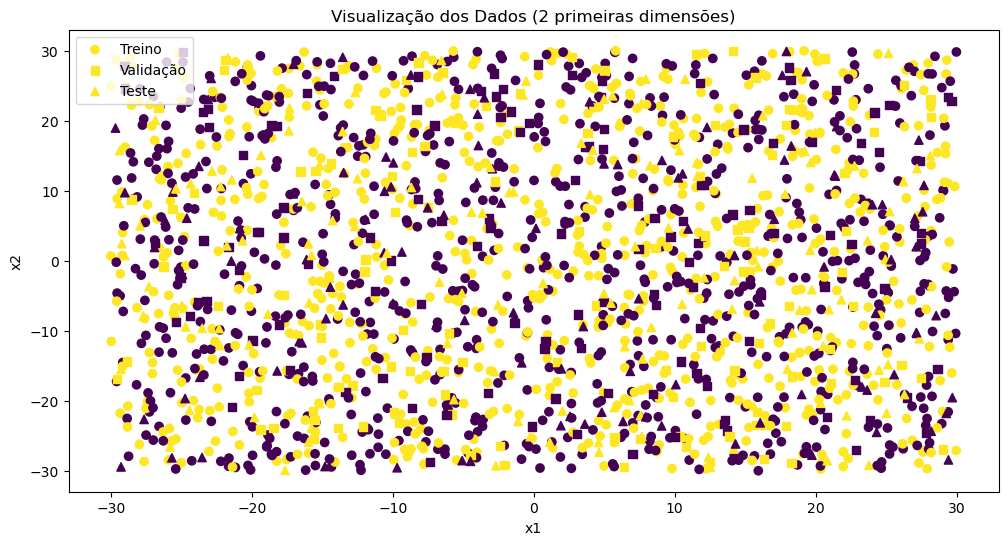

In [7]:
# Dividir em treino (1500), validação (250) e teste (250)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=500, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\n(b) Distribuição dos pontos:")
print(f"Treinamento: {X_train.shape[0]} pontos")
print(f"Validação: {X_val.shape[0]} pontos")
print(f"Teste: {X_test.shape[0]} pontos")

# Normalizar os valores de y para o intervalo [0,1]
norm = Normalize(vmin=min(y_train.min(), y_val.min(), y_test.min()), 
                vmax=max(y_train.max(), y_val.max(), y_test.max()))

plt.figure(figsize=(12, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=norm(y_train), cmap='viridis', label='Treino')
plt.scatter(X_val[:, 0], X_val[:, 1], c=norm(y_val), cmap='viridis', marker='s', label='Validação')
plt.scatter(X_test[:, 0], X_test[:, 1], c=norm(y_test), cmap='viridis', marker='^', label='Teste')

plt.title("Visualização dos Dados (2 primeiras dimensões)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

#### Tridimensional

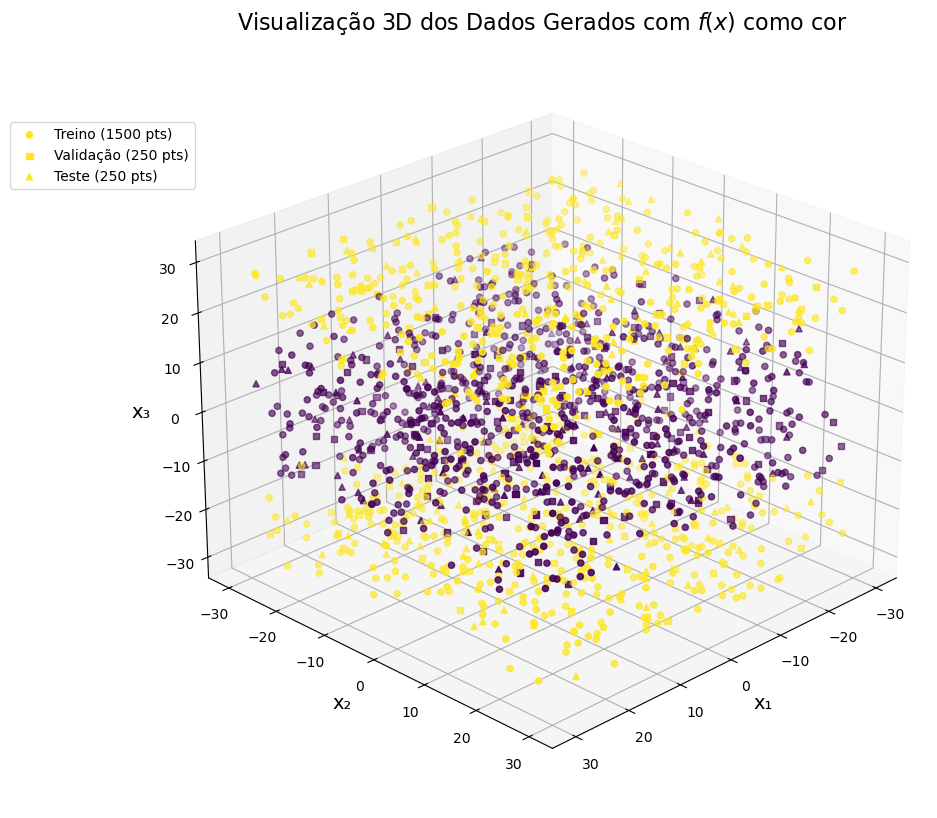

In [8]:
# Configuração do gráfico 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot dos pontos de treinamento
sc_train = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], 
                      c=y_train, cmap='viridis', 
                      label='Treino (1500 pts)', marker='o')

# Plot dos pontos de validação
sc_val = ax.scatter(X_val[:, 0], X_val[:, 1], X_val[:, 2], 
                    c=y_val, cmap='viridis', 
                    label='Validação (250 pts)', marker='s')

# Plot dos pontos de teste
sc_test = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], 
                     c=y_test, cmap='viridis', 
                     label='Teste (250 pts)', marker='^')

# Configurações do gráfico
ax.set_title(f'Visualização 3D dos Dados Gerados com $f(x)$ como cor', fontsize=16)
ax.set_xlabel('x₁', fontsize=14)
ax.set_ylabel('x₂', fontsize=14)
ax.set_zlabel('x₃', fontsize=14)

# Ajustando a legenda
ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 0.9))

# Ajustando o ângulo de visualização
ax.view_init(elev=25, azim=45)
plt.show()

## Treinamento

Como estamos tratando de um problema de regressão, uma vez que não temos as classes dos pontos bem definidas, temos que ajustar as métricas e os modelos para atuarem como regressores.

- Modelos:
    - MLP-BP de Três Camadas: usaremos o [MLPRegressor da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
    - RBF de Três Camadas: construí uma rotina própria de RBF com k-means
    - SVM com Kernel: usaremos o [SVR da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

- Métricas:
    - Mean Squared Error: usaremos o [MSE da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) para analisar o quanto o modelo está errando
    - $R^2$ Score: usaremos o [$R^2$ da Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) para analisar o desempenho global dos modelos

### Função para avaliação de modelos

In [9]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Avalia um modelo e retorna métricas"""
    model.fit(X_train, y_train)
    
    # Previsões
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    # Métricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    mse_test = mean_squared_error(y_test, y_pred_test)

    acc_train= accuracy_score(y_train, y_pred_train)
    acc_val= accuracy_score(y_val, y_pred_val)
    acc_test= accuracy_score(y_test, y_pred_test)
    
    return {
        'mse': {'train': mse_train, 'val': mse_val, 'test': mse_test},
        'acc': {'train': acc_train, 'val': acc_val, 'test': acc_test}
    }, y_pred_train,y_pred_val,y_pred_test


### Normalização dos Dados

Fazemos isso para que os valores numéricos não estourem. Para tal, usamos o [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) que atua como um z-score:
$$
z=\frac{x - \mu}{\sigma}
$$

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### (c) MLP-BP de três camadas

Implementei um MLP de 3 camadas em que:
- Camada escondida contém apenas 20 neurônios;
- Função de ativação para o cálculo do Net é a 'ReLU' $\equiv$ Rectified Linear Unit Function
- Regra de Atualização dos Pesos: 'adam'
- Número Máximo de Iterações: 1000

In [11]:
print("\n(c) Treinando MLP-BP de três camadas...")
mlp = MLPClassifier(hidden_layer_sizes=(20,), activation='relu',
                solver='adam', max_iter=1000, random_state=42)

mlp_metrics, y_mlp_pred_train,y_mlp_pred_val,y_mlp_pred_test = evaluate_model(mlp, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

print("Accuracy - Treino:", mlp_metrics['acc']['train'], "| Validação:", mlp_metrics['acc']['val'], "| Teste:", mlp_metrics['acc']['test'])
print("MSE - Treino:", mlp_metrics['mse']['train'], "| Validação:", mlp_metrics['mse']['val'], "| Teste:", mlp_metrics['mse']['test'])

#Imprimindo os Pesos e os Biases Finais Utilizados
print("\nPesos Finais Utilizados:")
print(mlp.coefs_)
print("\nBiases Finais Utilizados:")
print(mlp.intercepts_)


(c) Treinando MLP-BP de três camadas...
Accuracy - Treino: 0.996 | Validação: 0.996 | Teste: 1.0
MSE - Treino: 0.004 | Validação: 0.004 | Teste: 0.0

Pesos Finais Utilizados:
[array([[-1.49449615e-02,  2.07447635e-02,  5.54207655e-01,
         3.14050960e-01, -5.57145537e-01,  1.09665687e-01,
        -3.18957546e-02,  4.11631227e-04,  2.42979570e-83,
        -3.03305110e-02, -8.77204735e-01,  1.66063964e-02,
        -8.83890258e-03, -4.36595105e-02, -7.12597133e-02,
        -3.12212500e-02, -2.34073103e-02, -2.27746909e-02,
        -9.82814102e-02, -1.50420632e-01],
       [ 5.32210428e-02,  5.02498127e-02, -3.73592062e-01,
        -5.12913958e-01, -5.56080500e-01,  8.77239538e-01,
         5.52923645e-02,  4.83143488e-02, -1.30009027e-84,
         5.16791968e-02,  1.79156023e-01,  2.11675151e-02,
         1.83060280e-03,  4.36165033e-02,  1.16407070e-01,
         2.01647892e-02,  6.33771188e-02,  5.76858778e-02,
         6.45646764e-01, -1.29234143e-02],
       [-1.48857655e+00, -2.1

### (d) RBF de três camadas

Construí uma RBF de forma que:
- Usa K-means para encontrar centros representativos nos dados em que $K=50$ centros;
- Calcula a ativação de cada neurônio RBF usando função Gaussiana: $φ(||\vec{x}_n - c_i||) = exp(-||\vec{x}_n - c_i||² / (2σ²))$, o que faz com que cada neurônio responda mais intensamente a pontos próximos ao seu centro;
- Camada de saída com combinação linear das ativações RBF;
- Usa pseudoinversa para resolver o sistema linear (mais estável que inversão direta);

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import LabelBinarizer

class RBFClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_centers=50, sigma=1.0):
        self.n_centers = n_centers  # Número de neurônios na camada oculta
        self.sigma = sigma          # Largura das funções RBF
        
    def _rbf_function(self, X, centers):
        return np.exp(-cdist(X, centers, 'sqeuclidean') / (2 * self.sigma**2))
    
    def fit(self, X, y):
        # Converter y para formato binário se necessário (ex: [0, 1])
        self.label_binarizer_ = LabelBinarizer()
        y_bin = self.label_binarizer_.fit_transform(y).ravel()
        
        # Camada 1: Encontrar centros com K-means
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers_ = kmeans.cluster_centers_
        
        # Camada 2: Calcular saídas RBF
        rbf_features = self._rbf_function(X, self.centers_)
        
        # Camada 3: Regressão Logística (usando pseudoinversa)
        self.weights_ = np.linalg.pinv(rbf_features) @ y_bin
        
        return self
        
    def predict(self, X):
        rbf_features = self._rbf_function(X, self.centers_)
        linear_output = rbf_features @ self.weights_
        
        # Aplicar função sigmoide para probabilidades
        probabilities = 1 / (1 + np.exp(-linear_output))
        
        # Decisão binária (threshold = 0.5)
        return (probabilities >= 0.5).astype(int)
    
    def predict_proba(self, X):
        """Retorna as probabilidades de cada classe"""
        rbf_features = self._rbf_function(X, self.centers_)
        linear_output = rbf_features @ self.weights_
        probabilities = 1 / (1 + np.exp(-linear_output))
        return np.column_stack([1 - probabilities, probabilities])  # [P(y=0), P(y=1)]
    
rbf = RBFClassifier()

rbf_metrics, y_rbf_pred_train,y_rbf_pred_val,y_rbf_pred_test = evaluate_model(rbf, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
print("Accuracy - Treino:", rbf_metrics['acc']['train'], "| Validação:", rbf_metrics['acc']['val'], "| Teste:", rbf_metrics['acc']['test'])
print("MSE - Treino:", rbf_metrics['mse']['train'], "| Validação:", rbf_metrics['mse']['val'], "| Teste:", rbf_metrics['mse']['test'])

# Imprimindo os centros finais
print("\nCentros finais utilizados:")
print(rbf.centers_)

Accuracy - Treino: 0.7166666666666667 | Validação: 0.696 | Teste: 0.732
MSE - Treino: 0.2833333333333333 | Validação: 0.304 | Teste: 0.268

Centros finais utilizados:
[[ 0.46057846  0.80667904 -0.48209908]
 [-1.12096508 -0.50048307  1.36988296]
 [ 0.55209187  0.25296892  1.35018956]
 [-0.97716343 -0.23870371 -1.37668172]
 [ 0.44629816 -1.12993786 -0.93862846]
 [-1.39797151  1.01527053  0.3170208 ]
 [ 0.17727225 -1.2814488   0.74570554]
 [ 0.63036203 -0.38260551  0.29072563]
 [-0.66592946  0.87629654 -0.12471984]
 [-1.33550674 -1.43748992 -0.05658016]
 [-1.39657733  1.15400183 -1.3318278 ]
 [ 1.22895625  1.29348949  0.81496228]
 [ 1.26485206  0.19411633 -1.11954386]
 [ 1.34691819 -0.81981882 -0.0292166 ]
 [-0.35147353  1.03619091  1.47464359]
 [-1.05242236 -1.3740765   0.59329821]
 [-1.36420467 -1.08527224 -1.27206692]
 [-0.20335398 -0.04853397 -0.28487743]
 [-0.55933835  1.11385022 -1.33220225]
 [ 1.3183862   1.41131188 -0.21811388]
 [ 0.4846463  -0.66474595  1.34084913]
 [-1.30422189 

### (e) SVM com Kernel

Implementei um SVM Regressor (SVR) de tal forma que:
- Kernel do SVR é RBF;
    - Kernel Gaussiano: $\mathbf{K}(x, x') = exp(-\gamma * ||x - x'||^2)$
        - $\gamma$: controla a "largura";
        - $||x - x'||^2$: é a distância euclidiana ao quadrado.
    - Com essa Tranformação de Núcleo, conseguimos mapear o problema para um espaço de dimensão superior e fazer a regressão
- gamma: Controla o alcance da influência de cada ponto de treinamento
    - Valores baixos: decisão mais suave (considera pontos mais distantes);
    - Valores altos: decisão mais complexa (considera pontos mais próximos);

In [13]:
print("\n(e) Treinando SVM com Kernel...")
svm = SVC(kernel='rbf', gamma=0.2)
svm_metrics, y_svm_pred_train,y_svm_pred_val,y_svm_pred_test = evaluate_model(svm, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
print("Accuracy - Treino:", svm_metrics['acc']['train'], "| Validação:", svm_metrics['acc']['val'], "| Teste:", svm_metrics['acc']['test'])
print("MSE - Treino:", svm_metrics['mse']['train'], "| Validação:", svm_metrics['mse']['val'], "| Teste:", svm_metrics['mse']['test'])



(e) Treinando SVM com Kernel...
Accuracy - Treino: 0.986 | Validação: 0.992 | Teste: 0.984
MSE - Treino: 0.014 | Validação: 0.008 | Teste: 0.016


### (f) Comparação dos resultados no cojunto de teste


Comparação dos modelos:

MLP-BP:
MSE Teste: 0.0000 | Acc Teste: 1.0000

RBF:
MSE Teste: 0.2680 | Acc Teste: 0.7320

SVM:
MSE Teste: 0.0160 | Acc Teste: 0.9840


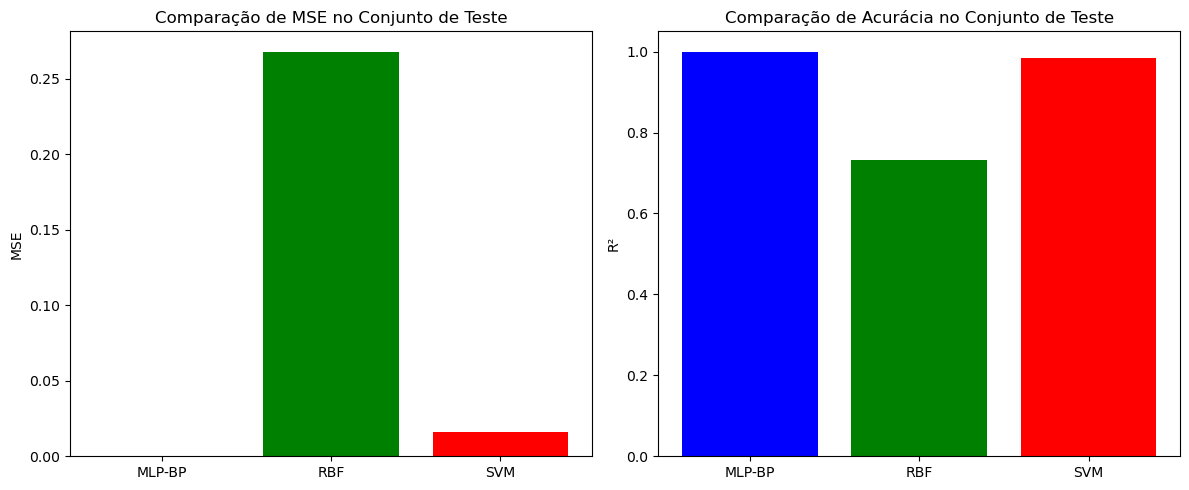

In [14]:
print("\nComparação dos modelos:")
print("\nMLP-BP:")
print(f"MSE Teste: {mlp_metrics['mse']['test']:.4f} | Acc Teste: {mlp_metrics['acc']['test']:.4f}")

print("\nRBF:")
print(f"MSE Teste: {rbf_metrics['mse']['test']:.4f} | Acc Teste: {rbf_metrics['acc']['test']:.4f}")

print("\nSVM:")
print(f"MSE Teste: {svm_metrics['mse']['test']:.4f} | Acc Teste: {svm_metrics['acc']['test']:.4f}")

# Plotar comparação
models = ['MLP-BP', 'RBF', 'SVM']
mse_test = [mlp_metrics['mse']['test'], rbf_metrics['mse']['test'], svm_metrics['mse']['test']]
r2_test = [mlp_metrics['acc']['test'], rbf_metrics['acc']['test'], svm_metrics['acc']['test']]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mse_test, color=['blue', 'green', 'red'])
plt.title('Comparação de MSE no Conjunto de Teste')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(models, r2_test, color=['blue', 'green', 'red'])
plt.title('Comparação de Acurácia no Conjunto de Teste')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


## Relatório

1. O MLP-BP apresentou o melhor desempenho geral, com menor MSE e maior Acurácia no conjunto de teste. Isso era esperado, pois redes neurais multicamadas são aproximadores universais de funções. Seu principal destaque vai para a rápida convergência do modelo que com menos robustez que os outros modelos (converge com menos de 1000 iterações e possui apenas 20 neurônios na camada oculta), consegue ter um desempenho superior aos outros dois. Contudo, conseguiríamos ajustar os outros modelos para que desempenhassem de forma parecida (ponto 4. deste breve relatório), porém aumentando suas complexidades.

2. O RBF teve um "pior" desempenho. Ele funciona bem para problemas com características radialmente simétricas, mas pode ter dificuldade com funções mais complexas.

3. O SVM com kernel RBF teve o segundo desempenho neste problema. SVMs são poderosos para classificação binária e, como binarizamos as classes, teve um excelente desempenho.

4. Pelos desempenhos nas etapas de validação, os modelos não me parecem ter perdido a capacidade de generalização.

5. Há modos de aumentar as respectivas acurácias (aqui, vistas pela acurácia). O problema passa a ser analisar se não há overfitting dos modelos ao aumentar seus desempenhos:
   - MLP-BP: não há melhoria aparente na minha configuração
   - RBF: Aumentar o número de centros na região de decisão
   - SVM com Kernel RBF: Aumentar o parâmetro gamma que controla o alcance da influência dos pontos no problema

6. A função proposta parece ser melhor aproximada pela arquitetura do MLP-BP.